# Analysis

## Intro

In [366]:
import numpy as np
import psycopg2
import pandas as pd
from web_app.psql_secrets import psql_params

In [367]:
conn = psycopg2.connect(**psql_params)
curr = conn.cursor()

curr.execute("SELECT name, author, editorial, price, review, description, five_stars, four_stars, "
			 "three_stars, two_stars, one_star, link, website FROM books")
tuples = curr.fetchall()

df = pd.DataFrame(tuples, columns=["name", "author", "editorial", "price", "review",
								   "description", "five_stars", "four_stars", "three_stars",
								   "two_stars", "one_star", "link", "website"])
indexes = pd.Series(df.index, index=df["link"])

curr.close()
conn.close()

In [368]:
df.head()

,name,author,editorial,price,review,description,five_stars,four_stars,three_stars,two_stars,one_star,link,website
0,fleur. mi desesperada decision,ariana godoy,montena,13500,"una noche es suficiente para cambiar tu vida, ...",formatolibro fisico autor ariana godoy editori...,100% (7),0% (0),0% (0),0% (0),0% (0),https://www.buscalibre.cl/libro-fleur-mi-deses...,1
1,nutricion emocional,fran sabal,planeta,10430,?por que el crecimiento personal es clave a la...,formatolibro fisico autor fran sabal editorial...,94% (76),5% (4),1% (1),0% (0),0% (0),https://www.buscalibre.cl/libro-nutricion-emoc...,1
2,una corte de rosas y espinas,sarah j. maas,planeta,13930,quito una vida. ahora tiene que pagar con su p...,formatolibro fisico autor sarah j. maas editor...,75% (6),25% (2),0% (0),0% (0),0% (0),https://www.buscalibre.cl/libro-una-corte-de-r...,1
3,ojos que no ven,carmen gloria lopez,sudamericana,10800,textos hibridos que apuntan a reflexionar sobr...,formatolibro fisico autor carmen gloria lopez ...,0% (0),0% (0),0% (0),0% (0),0% (0),https://www.buscalibre.cl/libro-ojos-que-no-ve...,1
4,casa de tierra y sangre (ciudad medialuna 1),sarah j. maas,alfaguara,15390,unidos por la sangre. tentados por el deseo. l...,formatolibro fisico autor sarah j. maas editor...,87% (120),9% (13),3% (4),1% (1),0% (0),https://www.buscalibre.cl/libro-casa-de-tierra...,1


In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         12867 non-null  object
 1   author       12867 non-null  object
 2   editorial    12867 non-null  object
 3   price        12867 non-null  int64 
 4   review       12867 non-null  object
 5   description  12867 non-null  object
 6   five_stars   12867 non-null  object
 7   four_stars   12867 non-null  object
 8   three_stars  12867 non-null  object
 9   two_stars    12867 non-null  object
 10  one_star     12867 non-null  object
 11  link         12867 non-null  object
 12  website      12867 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 1.3+ MB


In [370]:
df = df.copy()

## Creating New Features

In [371]:
import spacy
from web_app.get_stop_words import spanish_stop_words
import re
import gc

In [372]:
df["description"] = df["description"].apply(lambda x: " ".join(x.replace(",", ", ").split()))

In [373]:
book_format = []

for index, row in enumerate(df["description"]):
	if "fisico" in row.split():
		book_format.append("fisico")
	elif "formatoebook" in row.split():
		book_format.append("ebook")
	else:
		book_format.append("")

df.insert(13, "book_format", book_format)

In [374]:
book_category = []

for index, row in enumerate(df["description"]):
	splited_row = row.split()
	try:
		item = splited_row[splited_row.index("categoria") + 1]

		if "," in item:
			item += " " + splited_row[splited_row.index("categoria") + 2]

			if "," in splited_row[splited_row.index("categoria") + 2]:
				item += " " + splited_row[splited_row.index("categoria") + 3]

		book_category.append(item)

	except:
		book_category.append("")

df.insert(14, "book_category", book_category)

In [375]:
for index, row in enumerate(df["book_category"]):
	if row == "no":
		df.at[index, "book_category"] = "no-ficcion"

In [376]:
book_year = []

for index, row in enumerate(df["description"]):
	splited_row = row.split()

	try:
		book_year.append(splited_row[splited_row.index("ano") + 1])
	except:
		book_year.append("")

df.insert(15, "book_year", book_year)

In [377]:
for index in range(df.shape[0]):
	if df["book_year"].iloc[index] == "201726":
		df.at[index, "book_year"] = 2017
	elif df["book_year"].iloc[index] == "20021":
		df.at[index, "book_year"] = 2021
	elif df["book_year"].iloc[index] == "1a(1962)":
		df.at[index, "book_year"] = 1962
	elif df["book_year"].iloc[index] == "3":
		df.at[index, "book_year"] = np.nan
	else:
		try:
			df.at[index, "book_year"] = int(df.at[index, "book_year"])
		except:
			df.at[index, "book_year"] = np.nan

In [378]:
other_languages_amount = 0

for row in df["description"]:
	if "spa" not in row and "castel" not in row:
		other_languages_amount += 1

print(f"Número de Libros en Otro lenguaje: {other_languages_amount}")

Número de Libros en Otro lenguaje: 886


In [379]:
for index, row in enumerate(df["description"]):
	if "spa" not in row and "castel" not in row:
		df.drop(index=index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [380]:
book_pages = []

for index, row in enumerate(df["description"]):
	splited_row = row.split()

	try:
		book_pages.append(splited_row[splited_row.index("paginas") + 1])
	except:
		book_pages.append("")

df.insert(16, "book_pages", book_pages)

In [381]:
for index in range(df.shape[0]):
	try:
		df.at[index, "book_pages"] = int(df.at[index, "book_pages"])
	except:
		df.at[index, "book_pages"] = np.nan

In [382]:
nlp = spacy.load("es_core_news_sm")

def clean_string(string):
	for character in string:
		if character not in "abcdefghijklmnopqrstuvwxyz ":
			string = string.replace(character, "")

	document = nlp(string)

	return " ".join([word.lemma_ for word in document if word.lemma_ not in spanish_stop_words])

df["name_cleaned"] = df["name"].apply(lambda x: clean_string(x))

In [383]:
rating = []
raters = []

for index in range(df.shape[0]):
	star5 = int(re.search(r"\((.*?)\)", df["five_stars"].iloc[index]).group(1))
	star4 = int(re.search(r"\((.*?)\)", df["four_stars"].iloc[index]).group(1))
	star3 = int(re.search(r"\((.*?)\)", df["three_stars"].iloc[index]).group(1))
	star2 = int(re.search(r"\((.*?)\)", df["two_stars"].iloc[index]).group(1))
	star1 = int(re.search(r"\((.*?)\)", df["one_star"].iloc[index]).group(1))

	numerator = 5 * star5 + 4 * star4 + 3 * star3 + 2 * star2 + star1
	denominator = star5 + star4 + star3 + star2 + star1

	if denominator == 0:
		rating.append(0)
	else:
		rating.append(numerator / denominator)

	raters.append(denominator)

df.insert(18, "rating", rating)
df.insert(19, "raters", raters)

In [384]:
mean_rating = 0
for row in df["rating"]:
	mean_rating += row

mean_rating = mean_rating / df.shape[0]
max_raters = max(df["raters"])

def bayesian_rating(rating, raters):
	return rating * (raters / max_raters) + (1 - (raters / max_raters)) * mean_rating

In [385]:
bayesian_ratings = [
	bayesian_rating(df["rating"].iloc[i], df["raters"].iloc[i]) for i in range(df.shape[0])
]

df.insert(20, "bayesian_rating", bayesian_ratings)

In [386]:
def raw_string(string):
	for character in string:
		if character not in "abcdefghijklmnopqrstuvwxyz ":
			string = string.replace(character, "")

	return string

In [387]:
punctuations = []

for row in df["description"]:
	for character in row:
		if character not in "abcdefghijklmnopqrstuvwxyz ":
			punctuations.append(character)

punctuations = list(set(punctuations))

In [388]:
df["review_raw"] = df["review"].apply(lambda x: raw_string(x))

df["review_chars_count"] = df["review"].apply(lambda x: len(x))
df["review_words_count"] = df["review_raw"].apply(lambda x: len(x.split()))
df["review_uniques_count"] = df["review_raw"].apply(lambda x: len(set(x.split())))
df["review_stopwords_count"] = df["review_raw"].apply(
	lambda x: len([word for word in x.split() if word in spanish_stop_words])
)
df["review_non_stopwords_rate"] = (df["review_stopwords_count"] / df["review_words_count"])
df["review_mean_word_length"] = df["review_raw"].apply(
	lambda x: np.mean([len(word) for word in x.split()])
)
df["review_std_word_length"] = df["review_raw"].apply(
	lambda x: np.std([len(word) for word in x.split()])
)
df["review_punctuations_count"] = df["review"].apply(
	lambda x: len([char for char in x if char in punctuations])
)

df["review_sentence_count"] = df["review"].apply(
	lambda x: len([sent for sent in x.split(".") if len(sent) != 0])
)
df["review_mean_sentence_length"] = df["review"].apply(
	lambda x: np.mean([len(sent) for sent in x.split(".") if len(sent) != 0])
)
df["review_std_sentence_length"] = df["review"].apply(
	lambda x: np.std([len(sent) for sent in x.split(".") if len(sent) != 0])
)
df["review_max_sentence_length"] = df["review"].apply(
	lambda x: max([len(sent) for sent in x.split(".")])
)

/home/cris/miniconda3/envs/books/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cris/miniconda3/envs/books/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cris/miniconda3/envs/books/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cris/miniconda3/envs/books/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [389]:
df["book_year"] = pd.to_numeric(df["book_year"])
df["book_pages"] = pd.to_numeric(df["book_pages"])

In [390]:
del book_format, book_category, book_year, other_languages_amount
del book_pages, rating, raters, bayesian_ratings, punctuations
del mean_rating, max_raters, nlp

gc.collect()

14272

In [391]:
df = df.sample(frac=1, random_state=1234, ignore_index=True)

test_df = df[10_000:]
df = df[:10_000]

## Univariate Analysis

In [392]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

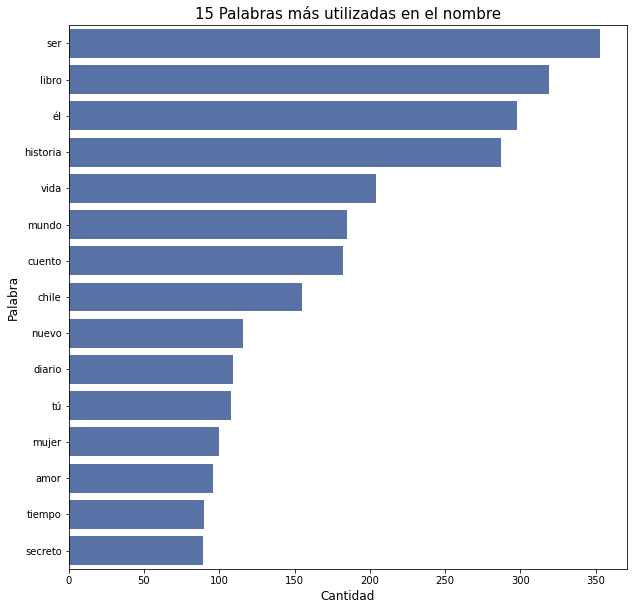

In [393]:
all_words = [word for row in df["name_cleaned"] for word in row.split()]

counts = Counter(all_words)
counts.most_common()

most_common_words = [word[0] for word in counts.most_common()[0:15]]
most_common_values = [word[1] for word in counts.most_common()[0:15]]

fig = plt.subplots(figsize=(10, 10))
sns.barplot(y=most_common_words, x=most_common_values, color="#4C6EB3")
plt.title("15 Palabras más utilizadas en el nombre", fontsize=15)
plt.xlabel("Cantidad", fontsize=12)
plt.ylabel("Palabra", fontsize=12)
plt.savefig("plots/most_common_words_in_names.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

In [394]:
df["price"].describe()

count     10000.00000
mean      11916.07900
std        9461.84127
min         970.00000
25%        7990.00000
50%       11240.00000
75%       14500.00000
max      667340.00000
Name: price, dtype: float64

In [395]:
print(f"Percentil 90: {np.percentile(df['price'], 95)}")

Percentil 90: 22600.0


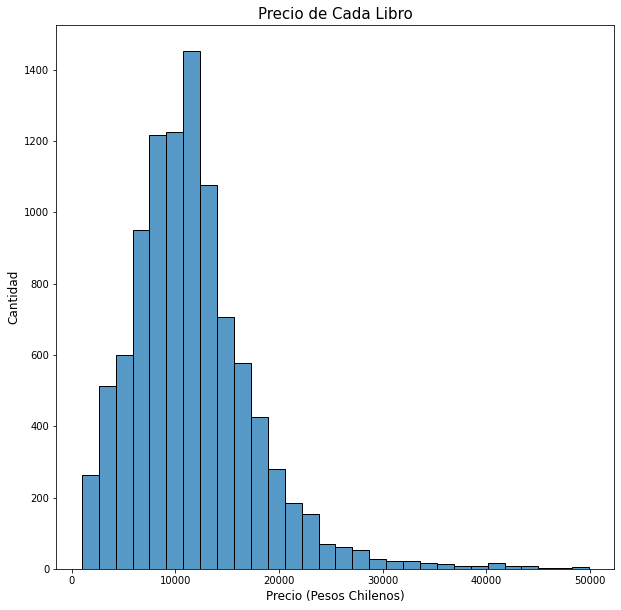

In [396]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df[df["price"] <= 50_000]["price"], bins=30)
plt.title("Precio de Cada Libro",
		  fontsize=15)
plt.xlabel("Precio (Pesos Chilenos)", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/price.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

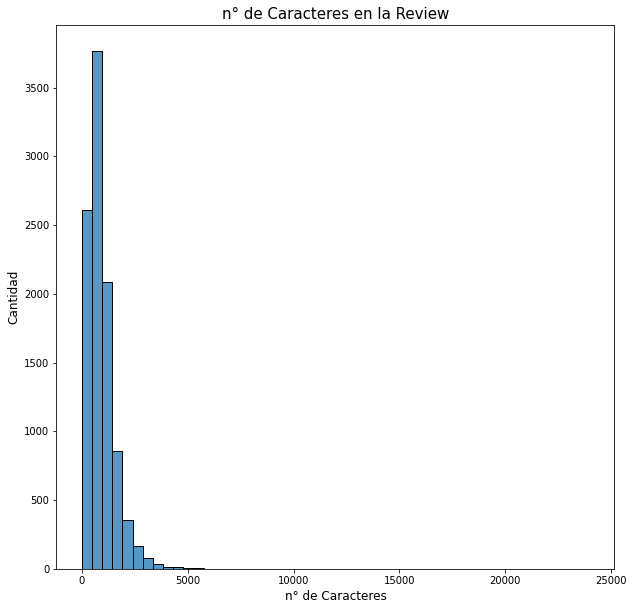

In [397]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_chars_count"], bins=50)
plt.title("n° de Caracteres en la Review",
		  fontsize=15)
plt.xlabel("n° de Caracteres", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/chars_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

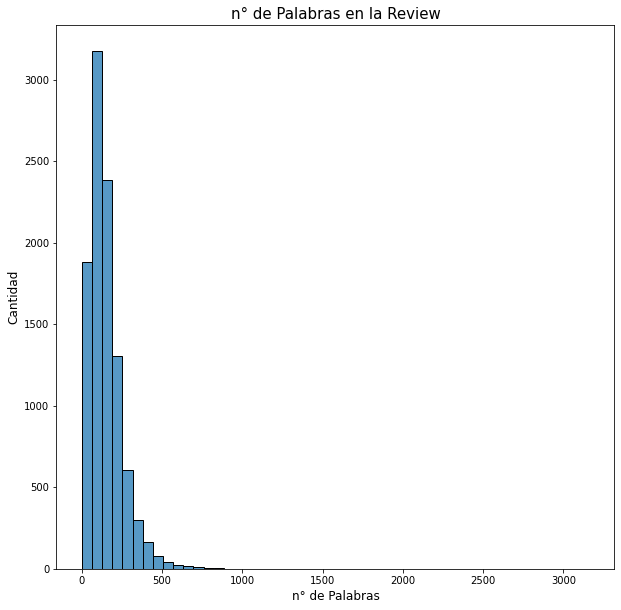

In [398]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_words_count"], bins=50)
plt.title("n° de Palabras en la Review",
		  fontsize=15)
plt.xlabel("n° de Palabras", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/words_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

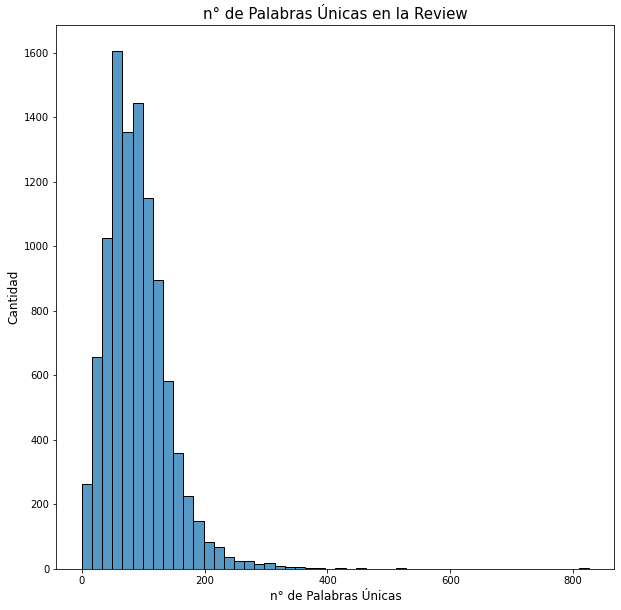

In [399]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_uniques_count"], bins=50)
plt.title("n° de Palabras Únicas en la Review",
		  fontsize=15)
plt.xlabel("n° de Palabras Únicas", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/uniques_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

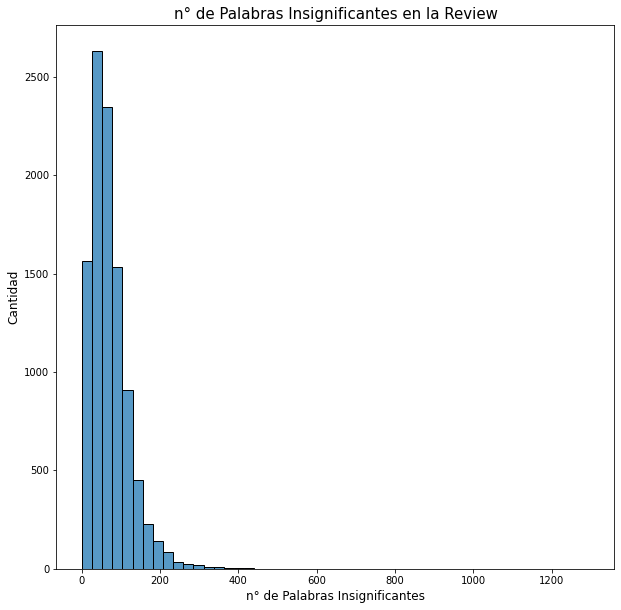

In [400]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_stopwords_count"], bins=50)
plt.title("n° de Palabras Insignificantes en la Review",
		  fontsize=15)
plt.xlabel("n° de Palabras Insignificantes", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/stopwords_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

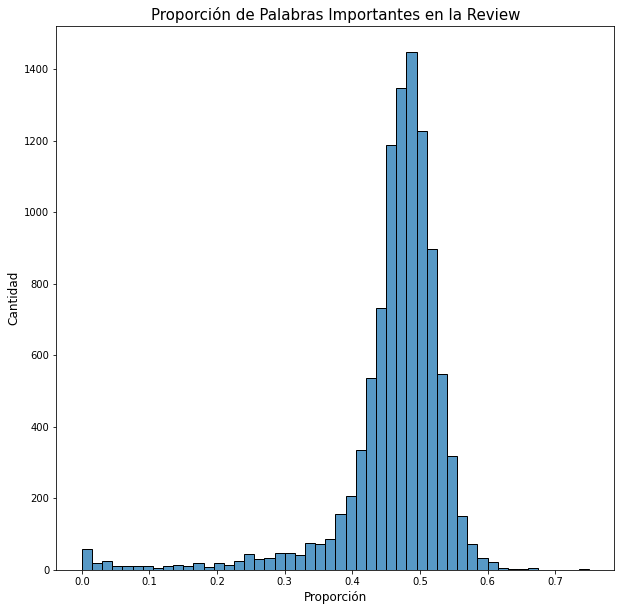

In [401]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_non_stopwords_rate"], bins=50)
plt.title("Proporción de Palabras Importantes en la Review",
		  fontsize=15)
plt.xlabel("Proporción", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/non_stopwords_rate.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

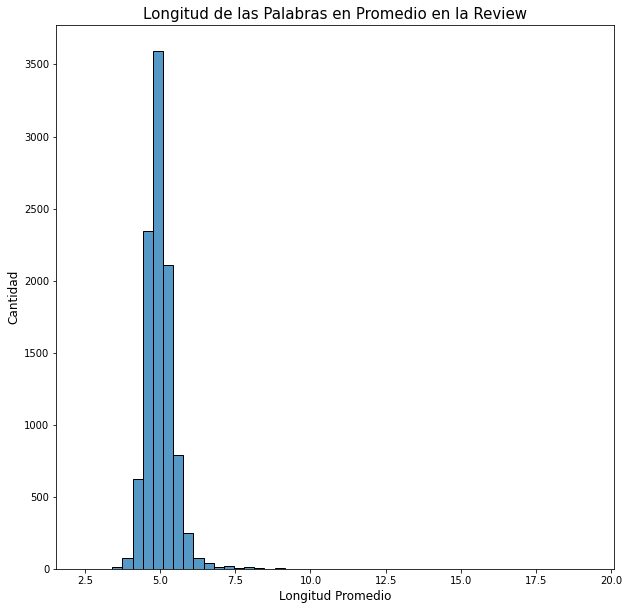

In [402]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_mean_word_length"], bins=50)
plt.title("Longitud de las Palabras en Promedio en la Review",
		  fontsize=15)
plt.xlabel("Longitud Promedio", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/mean_word_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

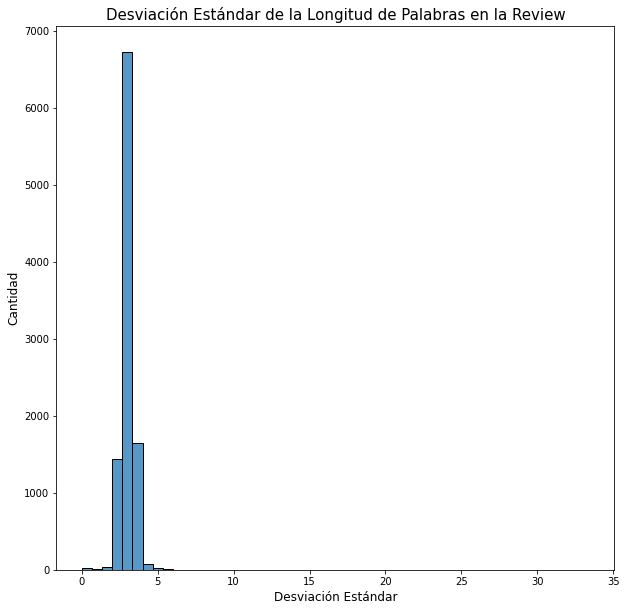

In [403]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_std_word_length"], bins=50)
plt.title("Desviación Estándar de la Longitud de Palabras en la Review",
		  fontsize=15)
plt.xlabel("Desviación Estándar", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/std_word_length.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

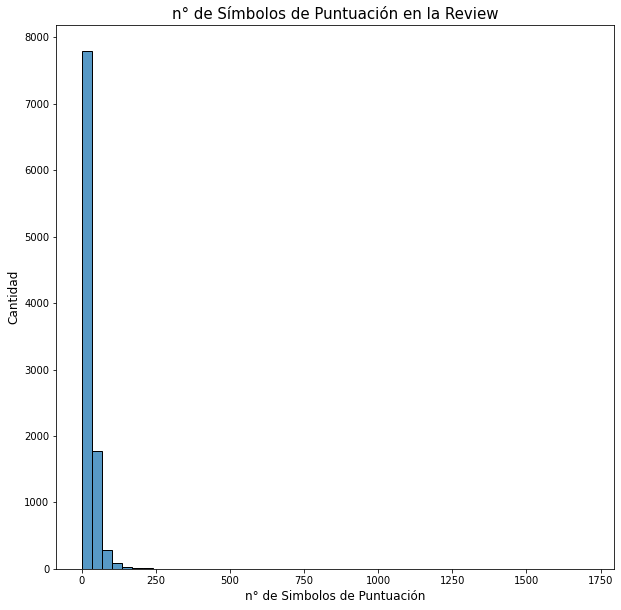

In [404]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_punctuations_count"], bins=50)
plt.title("n° de Símbolos de Puntuación en la Review",
		  fontsize=15)
plt.xlabel("n° de Simbolos de Puntuación", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/punctuations_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

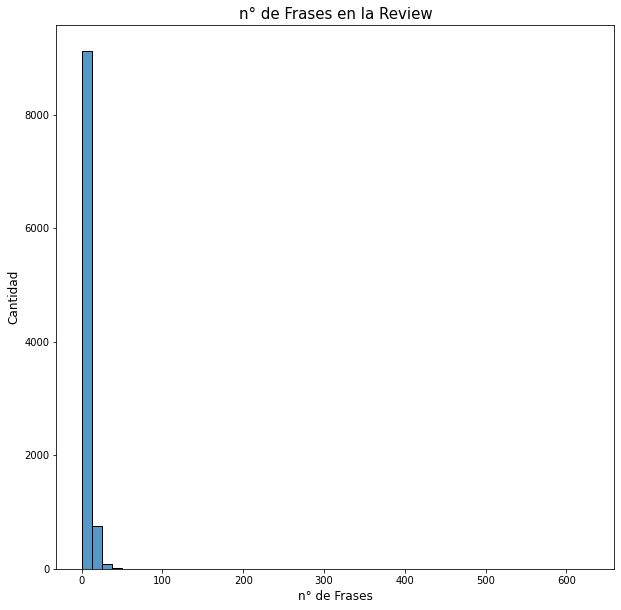

In [405]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_sentence_count"], bins=50)
plt.title("n° de Frases en la Review",
		  fontsize=15)
plt.xlabel("n° de Frases", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/sentences_count.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

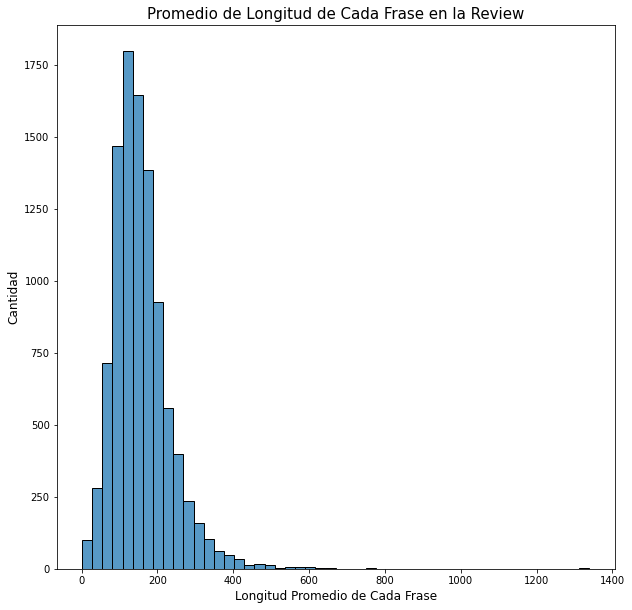

In [406]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_mean_sentence_length"], bins=50)
plt.title("Promedio de Longitud de Cada Frase en la Review",
		  fontsize=15)
plt.xlabel("Longitud Promedio de Cada Frase", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/mean_sentences_length.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

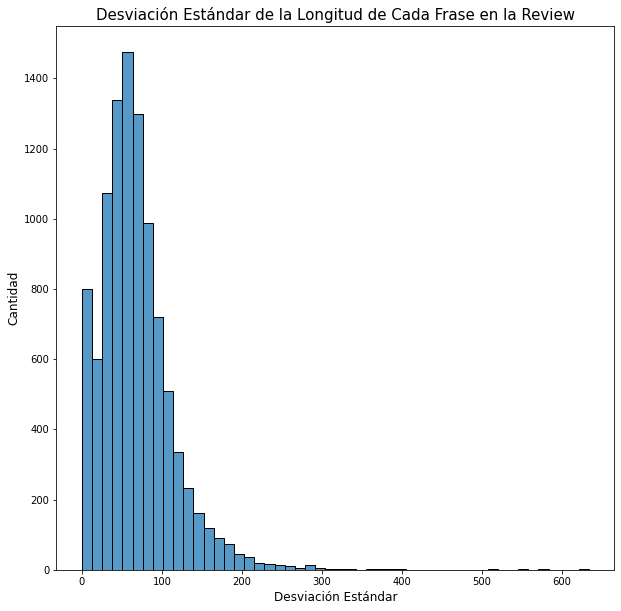

In [407]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_std_sentence_length"], bins=50)
plt.title("Desviación Estándar de la Longitud de Cada Frase en la Review",
		  fontsize=15)
plt.xlabel("Desviación Estándar", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/std_sentence_length.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

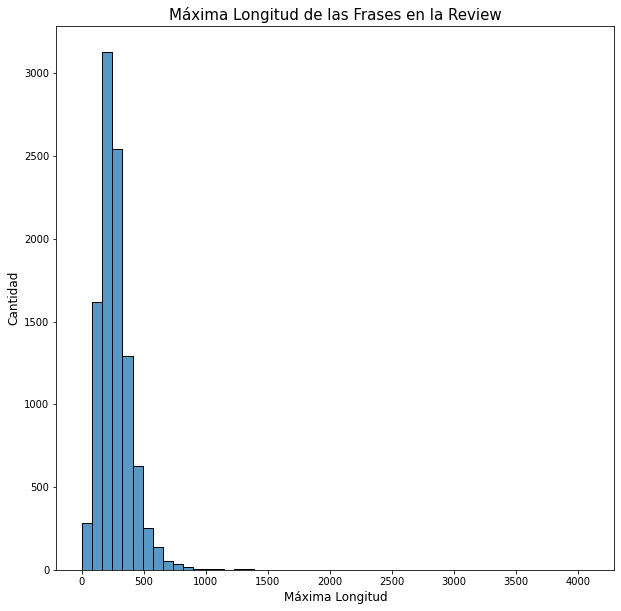

In [408]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["review_max_sentence_length"], bins=50)
plt.title("Máxima Longitud de las Frases en la Review",
		  fontsize=15)
plt.xlabel("Máxima Longitud", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/max_sentence_length.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

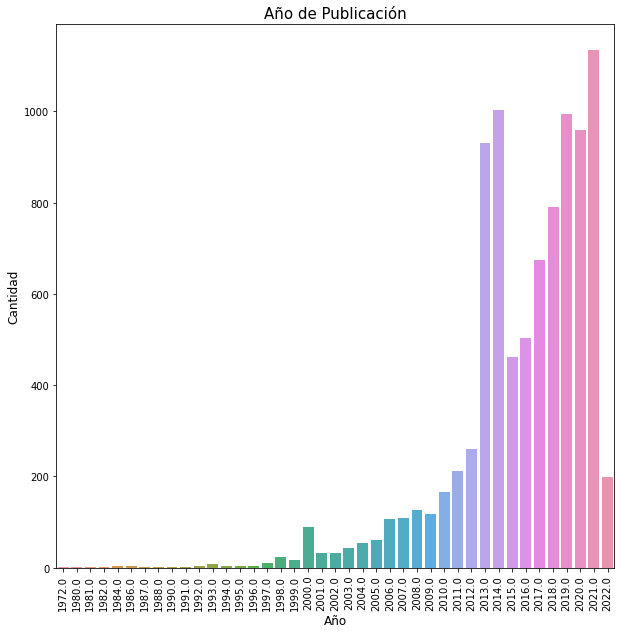

In [409]:
fig = plt.subplots(figsize=(10, 10))
sns.barplot(x=df[df["book_year"] >= 1950]["book_year"].value_counts().index,
			y=df[df["book_year"] >= 1950]["book_year"].value_counts().values)
plt.xticks(rotation=90)
plt.title("Año de Publicación", fontsize=15)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/year.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

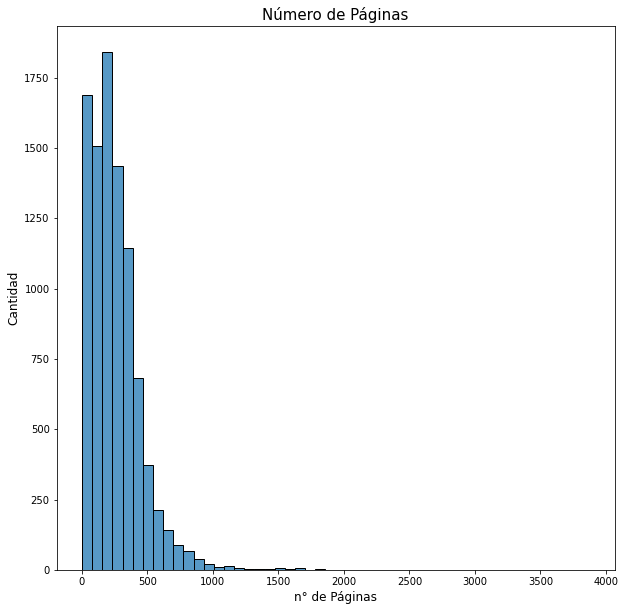

In [410]:
fig = plt.subplots(figsize=(10, 10))
sns.histplot(df["book_pages"], bins=50)
plt.title("Número de Páginas", fontsize=15)
plt.xlabel("n° de Páginas", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.savefig("plots/book_pages.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

In [411]:
df["raters"].sum()

42528

In [412]:
del all_words, counts, most_common_words, most_common_values, fig

gc.collect()

120351

## BiVariate Analysis

In [413]:
numeric_features = ["price", "book_year", "book_pages", "bayesian_rating", "review_chars_count",
					"review_words_count", "review_uniques_count", "review_stopwords_count",
					"review_non_stopwords_rate", "review_mean_word_length",
					"review_std_word_length", "review_punctuations_count", "review_sentence_count",
					"review_mean_sentence_length", "review_std_sentence_length",
					"review_max_sentence_length"]

In [414]:
df.drop(
	index=df[(df["book_year"].isna()) | (df["book_pages"].isna()) | (df["book_year"] < 1950)].index,
	inplace=True
)

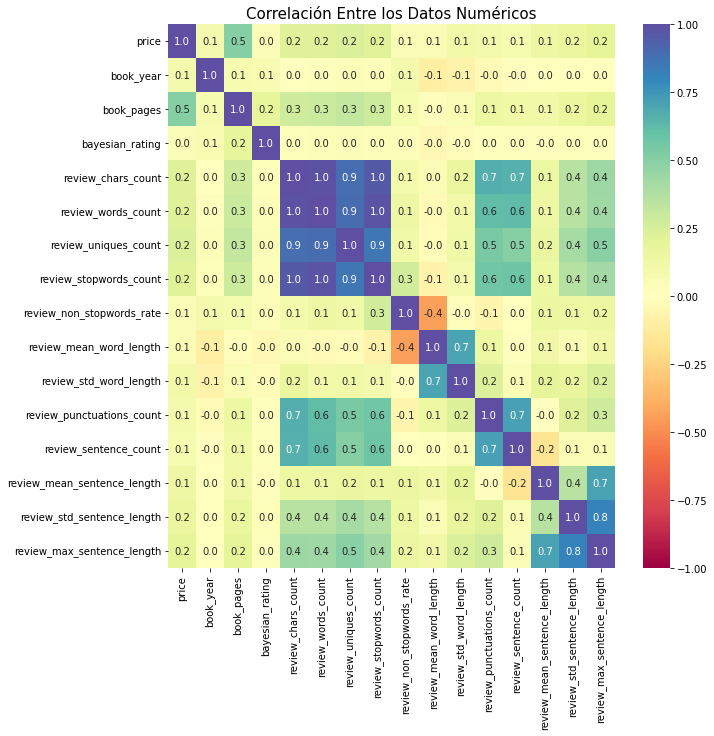

In [415]:
corr_matrix = df[numeric_features].corr()
fig = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="Spectral", vmin=-1, vmax=1, center=0)
plt.title("Correlación Entre los Datos Numéricos", fontsize=15)
plt.savefig("plots/numeric_correlation.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

In [416]:
important_cols = ["price", "book_year", "bayesian_rating", "review_chars_count",
				  "review_non_stopwords_rate", "review_mean_word_length",
				  "review_punctuations_count", "review_mean_sentence_length",
				  "review_std_sentence_length"]

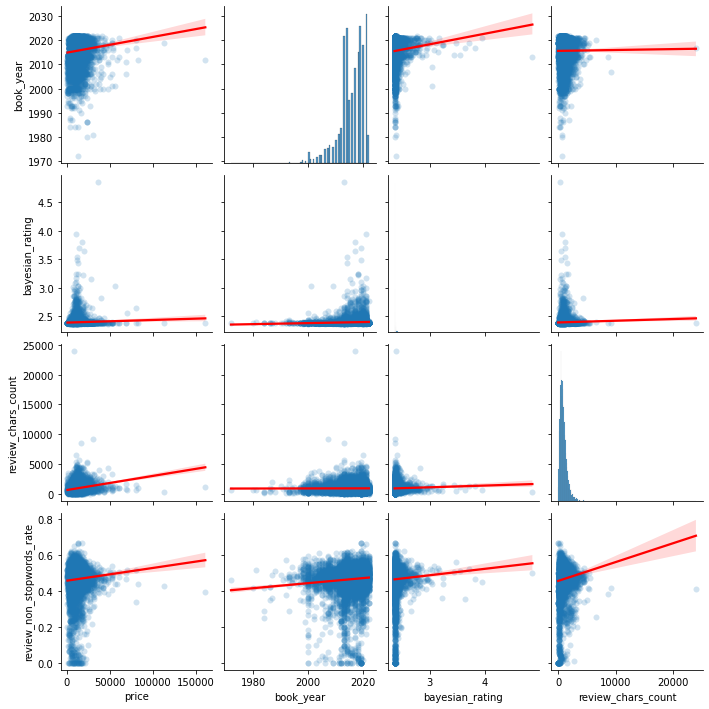

In [451]:
sns.pairplot(df[important_cols],
			 x_vars=["price", "book_year", "bayesian_rating", "review_chars_count"],
			 y_vars=["book_year", "bayesian_rating", "review_chars_count",
					 "review_non_stopwords_rate"],
			 kind="reg",
			 plot_kws={
				 "line_kws": {"color": "red"},
				 "scatter_kws": {"alpha": 0.2, "linewidth": 0}
			 },
			 grid_kws={"diag_sharey": False})
plt.savefig("plots/bivariate_pairplot1.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

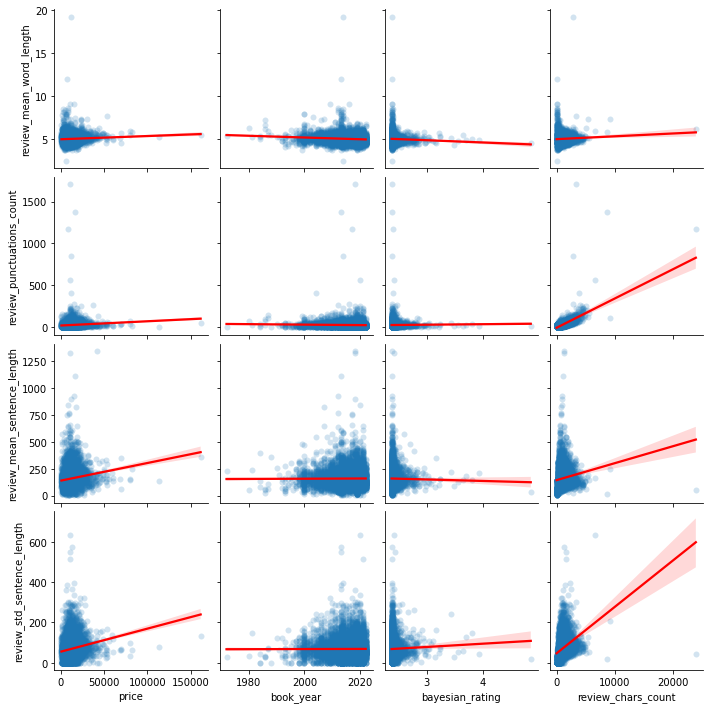

In [452]:
sns.pairplot(df[important_cols],
			 x_vars=["price", "book_year", "bayesian_rating", "review_chars_count"],
			 y_vars=["review_mean_word_length", "review_punctuations_count",
					 "review_mean_sentence_length", "review_std_sentence_length"],
			 kind="reg",
			 plot_kws={
				 "line_kws": {"color": "red"},
				 "scatter_kws": {"alpha": 0.2, "linewidth": 0}
			 },
			 grid_kws={"diag_sharey": False})
plt.savefig("plots/bivariate_pairplot2.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()

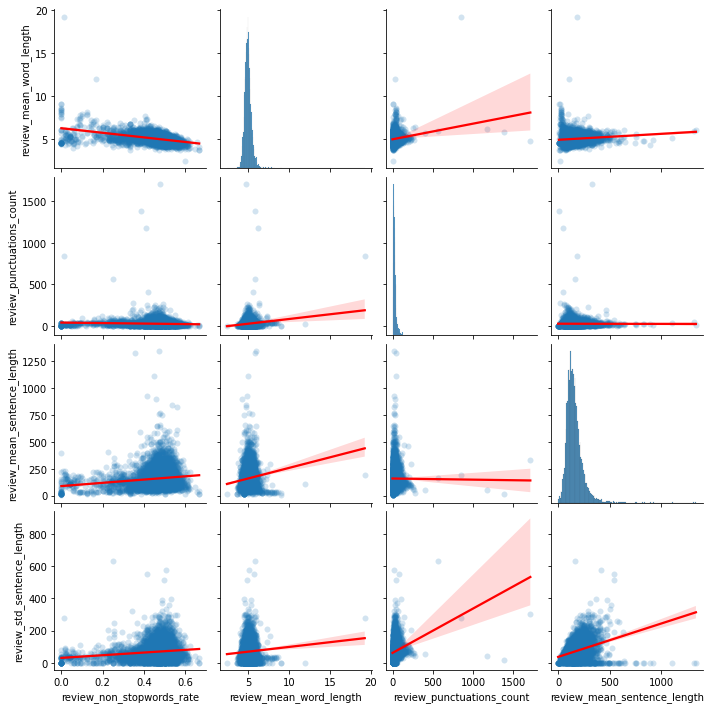

In [453]:
sns.pairplot(df[important_cols],
			 x_vars=["review_non_stopwords_rate", "review_mean_word_length",
					 "review_punctuations_count", "review_mean_sentence_length"],
			 y_vars=["review_mean_word_length", "review_punctuations_count",
					 "review_mean_sentence_length", "review_std_sentence_length"],
			 kind="reg",
			 plot_kws={
				 "line_kws": {"color": "red"},
				 "scatter_kws": {"alpha": 0.2, "linewidth": 0}
			 },
			 grid_kws={"diag_sharey": False})
plt.savefig("plots/bivariate_pairplot3.png", bbox_inches="tight", facecolor="#e3e3e3",
			pad_inches=0.3, transparent=False)
plt.show()